In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

rcParams['figure.figsize'] = 20,10

Using TensorFlow backend.


In [2]:
# Read in JPM_nn_df.csv and drop na and unneeded columns

JPM_NN_df = pd.read_csv('resources/JPM_nn_df.csv')
JPM_NN = JPM_NN_df.drop(columns = ['Unnamed: 0'])
JPM_NN = JPM_NN.dropna(inplace=False)

JPM_NN.count()

Date        1345
Open        1345
High        1345
Low         1345
Close       1345
Volume      1345
Dividend    1345
dtype: int64

In [ ]:
# Plot Closing Prices

plt.figure(figsize=(28,14))
plt.plot(JPM_NN['Close'], label='JP Morgan-Chase Closing Price History')
plt.savefig('JPM_4yr_data.png')
plt.show

In [4]:
# Prepare new dataframe with 2 dimensions

data = JPM_NN.sort_index(ascending=True, axis=0)
JPM_ma_NN = data.filter(['Date', 'Close'], axis=1)

JPM_ma_NN.head()

,Date,Close
0,2014-01-02,58.21
1,2014-01-03,58.66
2,2014-01-06,59.00
3,2014-01-07,58.32
4,2014-01-08,58.87


In [5]:
# Establish training and testing data ~60/40

JPM_NN_train = JPM_ma_NN[:1008]
JPM_NN_test = JPM_ma_NN[1008:]

In [6]:
# Fit data to model

JPM_ma_NN.shape, JPM_NN_train.shape, JPM_NN_test.shape

((1345, 2), (1008, 2), (337, 2))

In [7]:
# Train for min and max

JPM_NN_train['Date'].min(), JPM_NN_train['Date'].max(), JPM_NN_test['Date'].min(), JPM_NN_test['Date'].max()

('2014-01-02', '2018-01-02', '2018-01-03', '2019-05-07')

In [8]:
# Make the Predictions

predictions = []

for i in range(0,337):
    a = JPM_NN_train['Close'][len(JPM_NN_train)-337+i].sum() + sum(predictions)
    b = a/337
    predictions.append(b)

In [9]:
# Root Mean Square Error

rmse = np.sqrt(np.mean(np.power((np.array(JPM_NN_test['Close'])-predictions), 2)))
rmse

109.05749505202645

C:\Users\Owner\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Owner\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


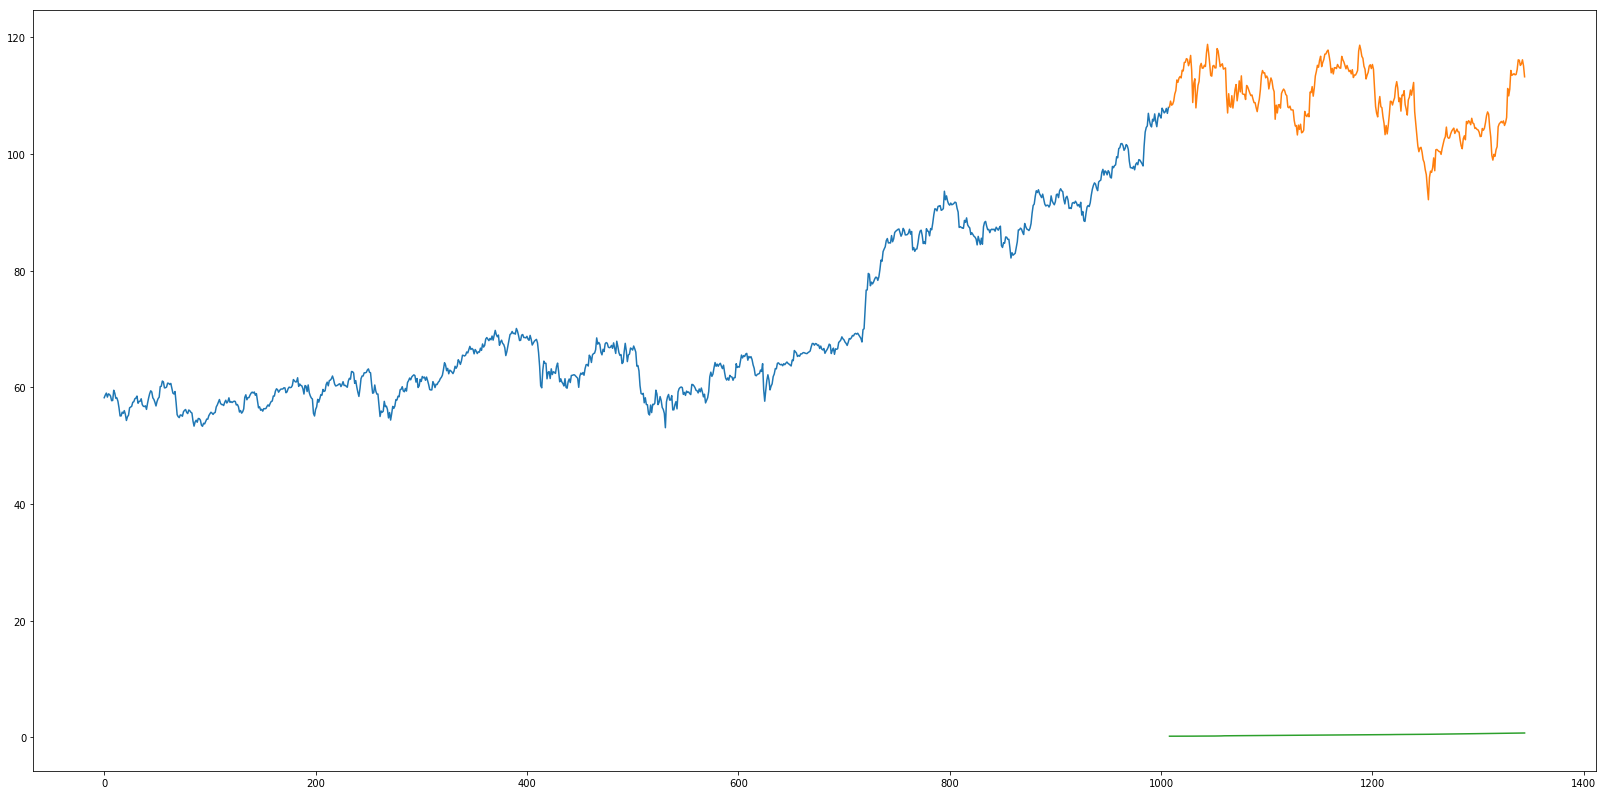

In [10]:
# Check the model via plot

JPM_NN_test['Predictions'] = 0
JPM_NN_test['Predictions'] = predictions

plt.figure(figsize=(28,14))
plt.plot(JPM_NN_train['Close'])
plt.plot(JPM_NN_test[['Close', 'Predictions']])

In [11]:
# Long Term Short Memory: Set up

data = JPM_NN_df.sort_index(ascending=True, axis=0)
JPM_prep = pd.DataFrame(index=range(0,len(JPM_NN_df)), columns=['Date', 'Close'])

for i in range(0,len(data)):
    JPM_prep['Date'][i] = data['Date'][i]
    JPM_prep['Close'][i] = data['Close'][i]
    
JPM_prep.index = JPM_prep.Date
JPM_prep.drop('Date', axis=1, inplace=True)

dataset = JPM_prep.values

train = dataset[0:1258, :]
test = dataset[1258:, :]

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [],[]
for i in range(60, len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))

C:\Users\Owner\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [12]:
# Create and fit data to LSTM network

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

inputs = JPM_prep[len(JPM_prep) - len(test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/1
 - 52s - loss: 0.0036


In [13]:
# Check results with RMSE

rmse = np.sqrt(np.mean(np.power((test-closing_price),2)))
rmse

2.302574134216657

In [ ]:
# Now plot

train = JPM_prep[:1258]
test = JPM_prep[1258:]

test['Predictions'] = closing_price

plt.figure(figsize=(28,14))
plt.plot(train['Close'])
plt.plot(test[['Close', 'Predictions']])
plt.savefig('JPM_predict_test.png')

C:\Users\Owner\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [15]:
test.head()

,Close,Predictions
Date,,
2019-01-02,99.31,96.828979
2019-01-03,97.11,97.147308
2019-01-04,100.69,97.383789
2019-01-07,100.76,97.887932
2019-01-08,100.57,98.491463


In [16]:
# Long Term Short Memory: Set up

data = JPM_NN_df.sort_index(ascending=True, axis=0)
JPM_prep = pd.DataFrame(index=range(0,len(JPM_NN_df)), columns=['Date', 'Close'])

for i in range(0,len(data)):
    JPM_prep['Date'][i] = data['Date'][i]
    JPM_prep['Close'][i] = data['Close'][i]
    
JPM_prep.index = JPM_prep.Date
JPM_prep.drop('Date', axis=1, inplace=True)

dataset = JPM_prep.values

train = dataset[0:1345, :]
test = dataset[1258:, :]

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [],[]
for i in range(60, len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))

# Create and fit data to LSTM network

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

inputs = JPM_prep[len(JPM_prep) - len(test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

# Check results with RMSE

rmse = np.sqrt(np.mean(np.power((test-closing_price),2)))
rmse


C:\Users\Owner\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


Epoch 1/1
 - 51s - loss: 0.0032


2.7704516546740567

C:\Users\Owner\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


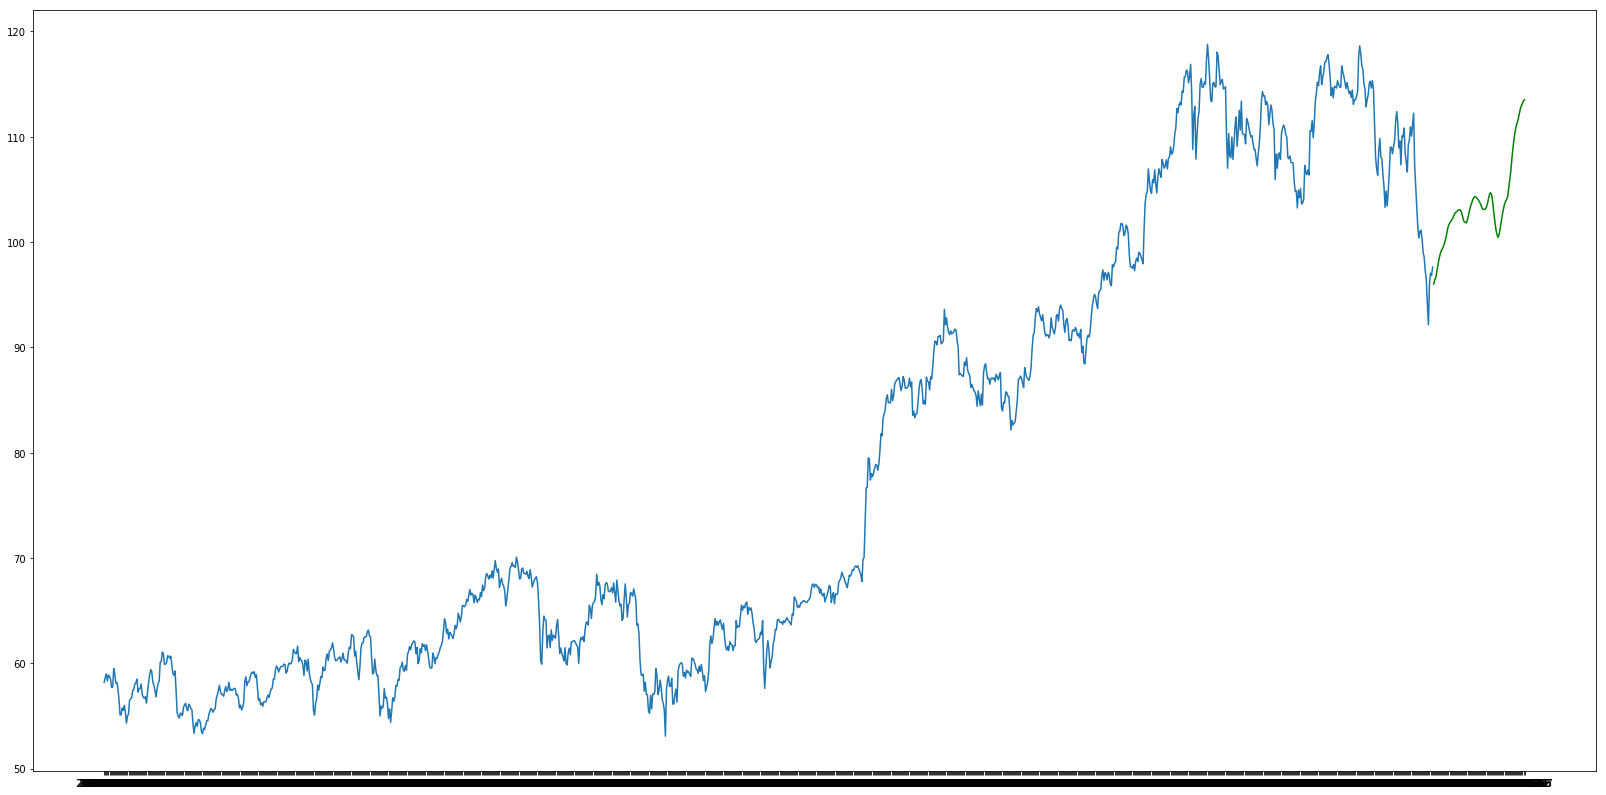

In [17]:
# Now plot

train = JPM_prep[:1258]
test = JPM_prep[1258:]

test['Predictions'] = closing_price

plt.figure(figsize=(28,14))
plt.plot(train['Close'])
plt.plot(test['Predictions'], 'g')
plt.savefig('JPM_predict_2019.png')

In [18]:
test['Predictions'].head()

test['Predictions'].to_csv('resources/JPM_pred.csv')